<a href="https://colab.research.google.com/github/pabloinsente/CovNet_Human_Drawings/blob/master/code/model_training_hyperparameter_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model training and hyperparameter optimization for Age-prediction
Here we use Keras and the Talos library to set up the hyperparameter optimization. 

***Warning***: since we are using colab, we need to (1) install talos (2) re-start the running environment (to update some packages that Talos needs to un) before running the optimization.  

In [0]:
!pip install talos

In [0]:
# Let's import Talos, Keras, and dependencies

import talos as ta
from talos.metrics.keras_metrics import precision_acc, recall_acc, matthews_correlation_acc, fmeasure_acc
from talos.model.normalizers import lr_normalizer

from keras.activations import relu, elu, sigmoid
from keras.optimizers import Adam, Nadam, RMSprop
from keras.losses import binary_crossentropy, logcosh
from keras.models import Sequential
from keras.layers import Dense, Dropout

from numpy import genfromtxt

%matplotlib inline

## Data preparation
First, we need to split the data into training and testing as usual. The training dataset will be feed into the model training and optimization process The testing data will be used to evalute the model. 

In [2]:
# Clone the data into Colab
! git clone https://github.com/pabloinsente/CovNet_Human_Drawings

Cloning into 'CovNet_Human_Drawings'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 588 (delta 28), reused 23 (delta 9), pack-reused 527
Receiving objects: 100% (588/588), 55.02 MiB | 20.88 MiB/s, done.
Resolving deltas: 100% (138/138), done.


In [3]:
# Get data
x_path= 'CovNet_Human_Drawings/data/merged_dataframes_prediction/x_train_drawings_features_max_pool_5_pca.csv'
y_path = 'CovNet_Human_Drawings/data/merged_dataframes_prediction/y_train_age_adult_labels.csv'

x = genfromtxt(x_path, delimiter=',')
y = genfromtxt(y_path, delimiter=',')

print(x.shape) # (258, 200)
print(y.shape) # (258,)

(258, 200)
(258,)


In [4]:
# Split data into train and test sets
# Since we have an small sample, we will do a 70/30 split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=44)
print(x_train.shape) # (180, 200)
print(y_train.shape) # (180,)
print(x_test.shape) # (78, 200)
print(y_test.shape) # (78,)

(180, 200)
(180,)
(78, 200)
(78,)


## Model Definition
Here we define the model using Keras. The main point is to pass all the arguments as keys of a Python dictionary instead of variables

In [0]:
# define model
def input_model(x_train, y_train, x_val, y_val, params):
  model = Sequential()
  # add hidden layer
  model.add(Dense(params['first_neuron'], 
                  input_dim=x_train.shape[1], 
                  activation=params['activation'],
                  kernel_initializer = params['kernel_initializer']))
  # add dropout layer
  model.add(Dropout(params['dropout']))
  # add output layer
  model.add(Dense(1,activation=params['last_activation'],
                  kernel_initializer = params['kernel_initializer']))
  # compile model
  model.compile(loss=params['losses'],
                optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])),
                metrics=['acc', fmeasure_acc, recall_acc, precision_acc, matthews_correlation_acc])
  # train model
  out = model.fit(x_train, y_train,
                  validation_data=[x_val, y_val],
                  batch_size=params['batch_size'],
                  # 180*.29 = ~52, which is ~20% of all data
                  #val_split = .29, 
                  epochs=params['epochs'])
  return out, model

## Setting the Parameter Space Boundaries 
here we create a dictionary, which will then be passed on to Talos together with the model above. Here we have three different ways to input values:

- as stepped ranges (min, max, steps)
- as multiple values [in a list]
- as a single value [in a list]

In [0]:
# set hyperparameters to optimize
p = {'first_neuron': [4, 8, 16, 32],
     'activation': [relu, sigmoid],
     'optimizer': [Nadam, Adam],
     'losses':[binary_crossentropy],
     'hidden_layers':[0, 1, 2],
     'batch_size': [10, 20, 30],
     'epochs':[4, 10, 25, 50],
     'dropout': [0, 0.1, 0.2],
     'kernel_initializer': ['uniform','normal'],
     'lr':[0.001, 0.01, 0.1],
     'last_activation': ['sigmoid']}

## Running the hyperparameter optimization with Scan() 
Now we are ready to run the model based on the parameters and the layer configuration above. The exact same process would apply with any other model, just make sure to pass the model function name in the Scan() command as in the below example. To get started quickly, we're going to invoke the 'grid_downsample' parameter to 10/100 of the entire permutations.



In [0]:
# starting optimization
# with the current hyperparameter space, taking a random sample of 10% will 
# run 518 models
h = ta.Scan(x= x_train, y=y_train,
            params=p,
            model=input_model,
            grid_downsample=.10)

## Accessing the results through the Scan object
The scan object saves all the necessary information for analysis and deployment
**See source code at** https://github.com/autonomio/talos/blob/daily-dev/talos/scan/Scan.py

In [59]:
# accessing the results data frame
h.data[0:3]

,round_epochs,val_loss,val_acc,val_fmeasure_acc,loss,acc,fmeasure_acc,first_neuron,activation,optimizer,losses,hidden_layers,batch_size,epochs,dropout,kernel_initializer,lr,last_activation
0,4,0.690543,0.763636,0.000000,0.690048,0.672,0.350667,16,<function sigmoid at 0x7faf18dfb840>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7faf18e49840>,0,30,4,0.1,uniform,0.01,sigmoid
1,10,0.691332,0.727273,0.268398,0.690578,0.784,0.081524,16,<function relu at 0x7faf18dfb730>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7faf18e49840>,0,10,10,0.0,normal,0.01,sigmoid
2,4,0.692836,0.672727,0.300275,0.692735,0.728,0.315472,4,<function relu at 0x7faf18dfb730>,<class 'keras.optimizers.Adam'>,<function binary_crossentropy at 0x7faf18e49840>,0,30,4,0.1,uniform,0.10,sigmoid


In [60]:
# Best model based on training criteria "val_acc"
# see source code to use https://github.com/autonomio/talos/blob/master/talos/utils/best_model.py
from talos.utils.best_model import best_model, activate_model
from talos import Predict

# get best model id from the scan object, based on f-measure accuracy
model_id = best_model(h, 'val_fmeasure_acc', False)
# activate best model based on model id
model = activate_model(h, model_id)
# makes probability predictions based on weights from best model
print(model.predict(x_test)[0:9,]) # print first 10
# makes class predictions based on weights from best model
print(model.predict_classes(x_test)[0:9,]) # print first 10

# All in one line
# activate_model(scan_object, best_model(scan_object, 'val_acc', False)).predict(X)

[[0.49851948]
 [0.49932215]
 [0.4986936 ]
 [0.49928543]
 [0.49902347]
 [0.49879903]
 [0.4991182 ]
 [0.4991543 ]
 [0.49925563]]
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [61]:
# accessing epoch entropy values for each round
h.peak_epochs_df[0:5] # print first 5 rows

,val_loss,val_acc,val_fmeasure_acc,loss,acc,fmeasure_acc,acc_epoch,loss_epoch
1,3,3,3,3,1,1,1.430999e-03,3.407251e-07
2,9,6,4,9,8,0,4.552545e-04,1.586281e-08
3,3,3,0,3,3,0,3.124634e-03,5.878659e-09
4,9,9,9,9,9,9,-2.322294e-16,7.868515e-07
5,9,9,9,4,1,1,1.159724e-03,1.424362e-07


In [62]:
# access the summary details
h.details

random_method          uniform_mersenne
reduction_method                   None
reduction_interval                   50
reduction_window                     20
grid_downsample                     0.1
reduction_threshold                 0.2
reduction_metric                val_acc
reduce_loss                       False
experiment_name           041519200034_
complete_time            04/15/19/20:36
x_shape                      (180, 200)
y_shape                          (180,)
dtype: object

In [63]:
# accessing the saved models
h.saved_models[0] # print first model

'{"class_name": "Sequential", "config": {"name": "sequential_1", "layers": [{"class_name": "Dense", "config": {"name": "dense_1", "trainable": true, "batch_input_shape": [null, 200], "dtype": "float32", "units": 16, "activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "RandomUniform", "config": {"minval": -0.05, "maxval": 0.05, "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dropout", "config": {"name": "dropout_1", "trainable": true, "rate": 0.1, "noise_shape": null, "seed": null}}, {"class_name": "Dense", "config": {"name": "dense_2", "trainable": true, "units": 1, "activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "RandomUniform", "config": {"minval": -0.05, "maxval": 0.05, "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "k

In [0]:
# accessing the saved weights for models
# h.saved_weights[0] # print weights first model

## Reporting optimization
In the Scan process, the results are stored round-by-round in the corresponding experiment log which is a .csv file stored in the present working directory. The Reporting() accepts as its source either a file name, or the Scan object.

**See source code to dcide how to use this command** 
https://github.com/autonomio/talos/blob/daily-dev/talos/commands/reporting.py 

In [0]:
# use Scan object as input
r = ta.Reporting(h) # creates report object from scan object

In [65]:
# access the dataframe with the results
r.data[0:3]

,round_epochs,val_loss,val_acc,val_fmeasure_acc,loss,acc,fmeasure_acc,first_neuron,activation,optimizer,losses,hidden_layers,batch_size,epochs,dropout,kernel_initializer,lr,last_activation
0,4,0.690543,0.763636,0.000000,0.690048,0.672,0.350667,16,<function sigmoid at 0x7faf18dfb840>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7faf18e49840>,0,30,4,0.1,uniform,0.01,sigmoid
1,10,0.691332,0.727273,0.268398,0.690578,0.784,0.081524,16,<function relu at 0x7faf18dfb730>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7faf18e49840>,0,10,10,0.0,normal,0.01,sigmoid
2,4,0.692836,0.672727,0.300275,0.692735,0.728,0.315472,4,<function relu at 0x7faf18dfb730>,<class 'keras.optimizers.Adam'>,<function binary_crossentropy at 0x7faf18e49840>,0,30,4,0.1,uniform,0.10,sigmoid


In [66]:
# get the number of rounds in the Scan
r.rounds()

1036

In [67]:
# get the highest result ('val_acc' by default)
r.high()

0.8181818236004222

In [68]:
# get the highest result for any metric
print("F-measure accuracy:", r.high('val_fmeasure_acc'))
print("Training accuracy:", r.high('acc'))
print("Validation accuracy:", r.high('val_acc'))

F-measure accuracy: 0.512121170759201
Training accuracy: 0.8400000023841858
Validation accuracy: 0.8181818236004222


In [69]:
# get the round with the best result
print(r.rounds2high('val_fmeasure_acc'))
print(r.rounds2high('acc'))
print(r.rounds2high('val_acc'))

178
128
546


In [70]:
# access the row with the highest f-measure validation value
h_value = r.high('val_fmeasure_acc')
r.data.loc[r.data['val_fmeasure_acc'] == h_value]

,round_epochs,val_loss,val_acc,val_fmeasure_acc,loss,acc,fmeasure_acc,first_neuron,activation,optimizer,losses,hidden_layers,batch_size,epochs,dropout,kernel_initializer,lr,last_activation
178,25,0.691958,0.763636,0.512121,0.692221,0.776,0.29304,4,<function relu at 0x7faf18dfb730>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7faf18e49840>,2,20,25,0.2,normal,0.01,sigmoid


In [71]:
# get the best paramaters
r.best_params(n=3) # return the best 3 sets of params

array([['uniform', 32, "<class 'keras.optimizers.Nadam'>", 25,
        '<function binary_crossentropy at 0x7faf18e49840>',
        '<function relu at 0x7faf18dfb730>', 0.001, 2, 0.0, 'sigmoid',
        20, 0],
       ['uniform', 4, "<class 'keras.optimizers.Adam'>", 10,
        '<function binary_crossentropy at 0x7faf18e49840>',
        '<function relu at 0x7faf18dfb730>', 0.1, 1, 0.1, 'sigmoid', 30,
        1],
       ['normal', 32, "<class 'keras.optimizers.Nadam'>", 25,
        '<function binary_crossentropy at 0x7faf18e49840>',
        '<function relu at 0x7faf18dfb730>', 0.1, 0, 0.2, 'sigmoid', 30,
        2]], dtype=object)

In [72]:
# get correlation for hyperparameters against a metric
print("Hyperparameters and f-measure accuracy")
print(r.correlate('val_fmeasure_acc'),"\n")
print("Hyperparameters and validation loss")
print(r.correlate('val_loss'),"\n")
print("Hyperparameters and validation accuracy")
print(r.correlate('val_acc'))

Hyperparameters and f-measure accuracy
first_neuron     0.048114
hidden_layers    0.042303
batch_size       0.093793
epochs           0.004612
dropout         -0.024489
lr              -0.142437
Name: val_fmeasure_acc, dtype: float64 

Hyperparameters and validation loss
first_neuron    -0.138480
hidden_layers   -0.009155
batch_size       0.090538
epochs          -0.275169
dropout          0.021375
lr              -0.423076
Name: val_loss, dtype: float64 

Hyperparameters and validation accuracy
first_neuron    -0.008519
hidden_layers   -0.044707
batch_size      -0.059162
epochs           0.180308
dropout          0.014738
lr               0.350725
Name: val_acc, dtype: float64


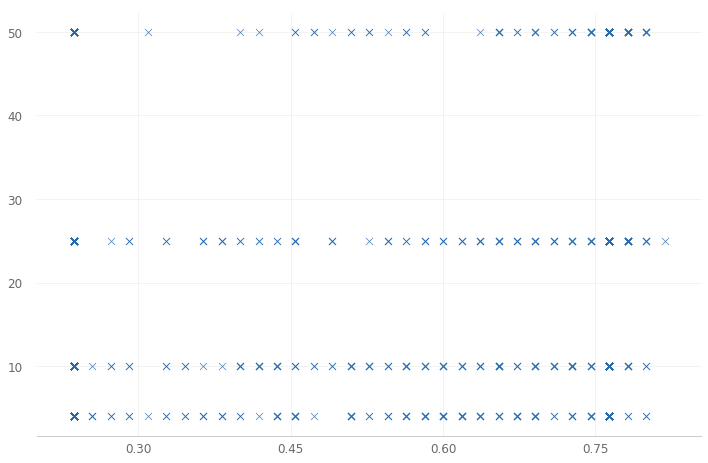

In [73]:
# a regression plot for two dimensions 
r.plot_regs("val_acc", "epochs")

None


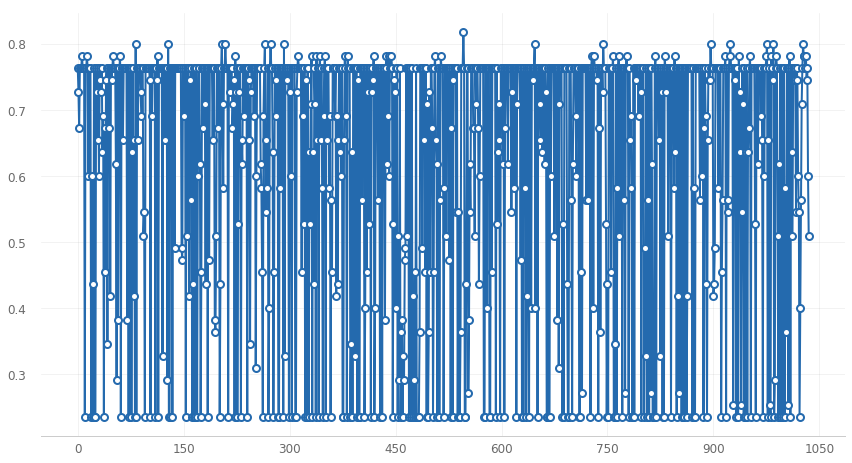

In [74]:
# line plot
print(r.plot_line("val_acc"))

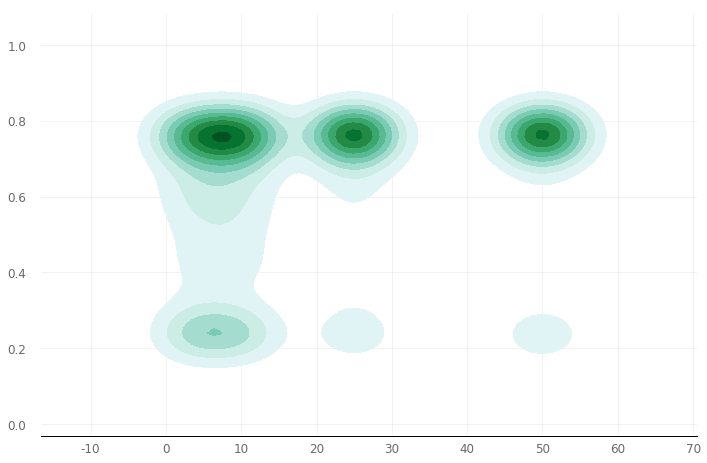

In [75]:
# up to two dimensional kernel density estimator
r.plot_kde("epochs","val_acc")

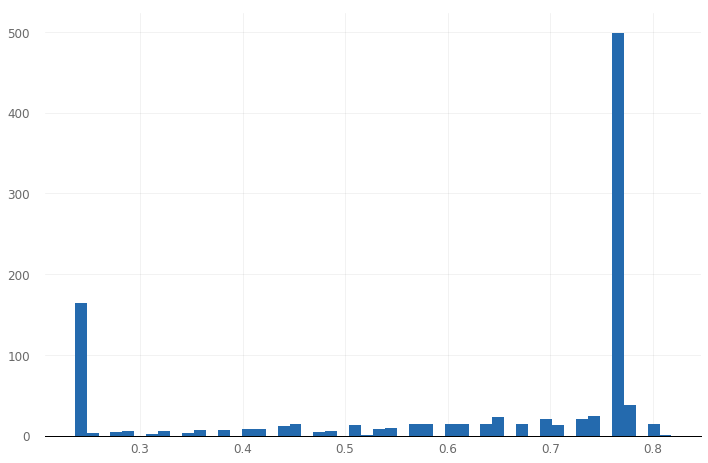

In [76]:
# a simple histogram
r.plot_hist(bins=50)

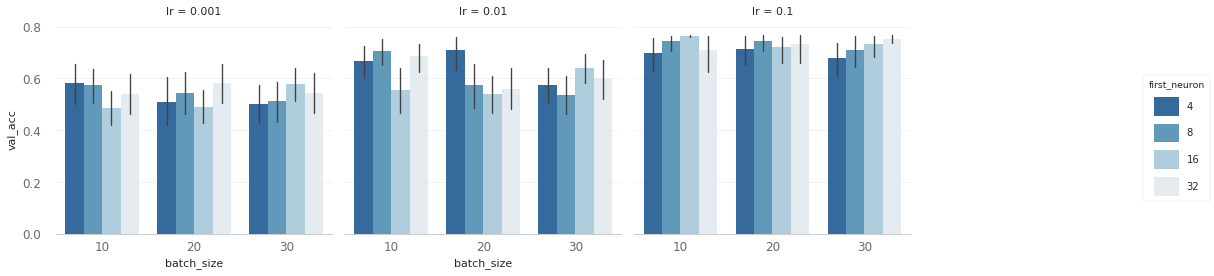

In [77]:
# a four dimensional bar grid
r.plot_bars('batch_size', 'val_acc', 'first_neuron', 'lr')

## Evaluating models
Models can be evaluated with Evaluate() against a k-fold cross-validation. Ideally at least 50% of the data, or more if possible, is kept completely out of the Scan process and only exposed into Evaluate once one or more candidate models have been identified.

**See source code at** https://github.com/autonomio/talos/blob/daily-dev/talos/commands/evaluate.py


In [78]:
# k-fols crossvalidation with 10 folds, from test data
# we're going to validate using the f-measure or harmonic mean since 
# combines precision and recall (optimize on that)
# https://en.wikipedia.org/wiki/Precision_and_recall#F-measure

e = ta.Evaluate(h)

e.evaluate(x=x_test, y=y_test,
           folds=10,
           shuffle=True,
           metric='val_fmeasure_acc',
           mode='binary',
           print_out=True)

mean : 0.05 
 std : 0.15


[0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

## Deploying models

Once the right model or models have been found, you can create a deployment package with Deploy() which is then easy to transfer to a production or other environment, send via email, or upload to shared remote location. Best model is automatically chosen based on a given metric ('val_acc' by default).

The Deploy package is a zip file that consist of:

- details of the scan
- model weights
- model json
- results of the experiment
- sample of x data
- sample of y data

**See source code at** https://github.com/autonomio/talos/blob/daily-dev/talos/commands/deploy.py

In [79]:
# By default selects the model with best validation accuracy "val_acc"
# Other metrics can be specified
ta.Deploy(h, 'drawings-exp2', metric='val_fmeasure_acc');

Deploy package drawings-exp2 have been saved.


## Restoring models
Restores the scan_object that had been stored locally as a result of talos.Deploy

**See source code at** https://github.com/autonomio/talos/blob/daily-dev/talos/commands/restore.py 

In [0]:
# Restore model from local environment
drawings = ta.Restore('drawings-exp2.zip')

In [81]:
# make predictions with the model
drawings.model.predict(x_test)[0:9,] # print first 10

array([[0.49851948],
       [0.49932215],
       [0.4986936 ],
       [0.49928543],
       [0.49902347],
       [0.49879903],
       [0.4991182 ],
       [0.4991543 ],
       [0.49925563]], dtype=float32)

In [82]:
# get the meta-data for the experiment/optimization
print(drawings.details)

                      0                 1
0         random_method  uniform_mersenne
1      reduction_method               NaN
2    reduction_interval                50
3      reduction_window                20
4       grid_downsample               0.1
5   reduction_threshold               0.2
6      reduction_metric           val_acc
7           reduce_loss             False
8       experiment_name     041519200034_
9         complete_time    04/15/19/20:36
10              x_shape        (180, 200)
11              y_shape            (180,)


In [83]:
# get the hyperparameter space boundary for the experiment/optimization
print(drawings.params)

OrderedDict([('first_neuron', [4, 8, 16, 32]), ('activation', [<function relu at 0x7faf18dfb730>, <function sigmoid at 0x7faf18dfb840>]), ('optimizer', [<class 'keras.optimizers.Nadam'>, <class 'keras.optimizers.Adam'>]), ('losses', [<function binary_crossentropy at 0x7faf18e49840>]), ('hidden_layers', [0, 1, 2]), ('batch_size', [10, 20, 30]), ('epochs', [4, 10, 25, 50]), ('dropout', [0, 0.1, 0.2]), ('kernel_initializer', ['uniform', 'normal']), ('lr', [0.001, 0.01, 0.1]), ('last_activation', ['sigmoid'])])


In [84]:
# sample of x and y data, returns pandas dataframe
print(drawings.x.iloc[0:3, 0:3]) # print first 3 rows and columns
print(drawings.y.iloc[0:3]) # print first 3 rows 

          0         1         2
0  0.217741 -0.107344  0.033749
1  0.323461  0.078702  0.230611
2 -0.010556 -0.111332  0.069449
     0
0  1.0
1  0.0
2  0.0


In [85]:
# the results dataframe
drawings.results[0:3] # print first 3 rows

,round_epochs,val_loss,val_acc,val_fmeasure_acc,loss,acc,fmeasure_acc,first_neuron,activation,optimizer,losses,hidden_layers,batch_size,epochs,dropout,kernel_initializer,lr,last_activation,Unnamed: 19
0,4,0.690543,0.763636,0.000000,0.690048,0.672,0.350667,16,<function sigmoid at 0x7faf18dfb840>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7faf18e49840>,0,30,4,0.1,uniform,0.01,sigmoid,0
1,10,0.691332,0.727273,0.268398,0.690578,0.784,0.081524,16,<function relu at 0x7faf18dfb730>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7faf18e49840>,0,10,10,0.0,normal,0.01,sigmoid,1
2,4,0.692836,0.672727,0.300275,0.692735,0.728,0.315472,4,<function relu at 0x7faf18dfb730>,<class 'keras.optimizers.Adam'>,<function binary_crossentropy at 0x7faf18e49840>,0,30,4,0.1,uniform,0.10,sigmoid,2


## Evaluating model on test set

### Confusion matrix

In [86]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict_classes(x_test) # predicted labels
y_true = y_test # true labels 

# Extract confusion matrix values
true_neg, false_pos, false_neg, true_pos = confusion_matrix(y_true, y_pred).ravel()
print("True negative:", true_neg, "\n")
print("True positive:", true_pos, "\n")
print("False negative:", false_neg, "\n")
print("False positive:", false_pos)

True negative: 63 

True positive: 1 

False negative: 12 

False positive: 2


### Classification report
- **accuracy:** true positives + true negatives/ total results OR OR *“for all instances, what percent was correct?”*
- **precision:** true positives / false positives + true positives OR *“for all instances classified positive, what percent was correct?”*
- **recall:** true positives / true positives + false negatives   OR  “for all instances that were actually positive, what percent was classified correctly?”
- **f1-score:** 2 * (precision * recall)/(precision + recall) // The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. 
-  **support:** is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing

**See documentation at** https://www.scikit-yb.org/en/latest/api/classifier/classification_report.html

In [87]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

classes = ["child", "adult"]

print("accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=classes))

accuracy: 0.8205128205128205
              precision    recall  f1-score   support

       child       0.84      0.97      0.90        65
       adult       0.33      0.08      0.12        13

   micro avg       0.82      0.82      0.82        78
   macro avg       0.59      0.52      0.51        78
weighted avg       0.76      0.82      0.77        78



# Resources
- **Talos repo**: https://github.com/autonomio/talos
- **Talos example**:  https://nbviewer.jupyter.org/github/autonomio/talos/blob/master/examples/Hyperparameter%20Optimization%20on%20Keras%20with%20Breast%20Cancer%20Data.ipynb